In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf
import csv
import sys
sys.path.append('/storage/home/hcoda1/4/ashelby8/Manitoba/pyNab/src/')
import nabPy as Nab
sys.path.append('/storage/home/hcoda1/4/ashelby8/calibration/calibration/')
from FitClass import SnCalibration
from config import conf
import FitFuncs
import pandas as pd
import pylab as py
np.set_printoptions(threshold=sys.maxsize)

# Output data format:
- read output file from calibration script
- create pandas DataFrame for data

In [78]:
with open('/storage/home/hcoda1/4/ashelby8/calibration/calibration/output1389.csv') as f:
    csv.DictReader(f)
    data = pd.read_csv(f)

In [79]:
pd.set_option("display.max_colwidth", 15)

- columns 3-8 display the slow data that is stored ( bias voltage, proton, proton energy, Cd119, Sn113, Date Time)
- trap rise/length/decay are the trap filter f=parameters used for the energy extraction
- "ecap" (column 12: data['ecap']) stores the fit parameters found for the electron capture peaks as a list
- "chi2_e" is the electron capture fit $\chi^2$
- "xray" (column 12: data['xray']) stores the fit parameters found for the low energy xray peaks/threshhold region
- "chi2_x" is the xray/low energy fit $\chi^2$
- "CE" and "Xray" are flags that indicate the fit class initialization
    - CE options:
        - 3: includes 363 peak and double gaussian for two higher lying peaks
        - 2: includes 363 peak and single gaussian for higher lying peaks (not enough counts for double gaussian)
        - 1: includes just the 363 peak (not enough counts for higher lying peaks)
        - 0: not enough counts for any gaussians
     - Xray options: I found a five gaussian fit to be very good for pixels with a large number of counts
        - 5: includes a threshold gaussian centered around 0, a double gaussian for the xray peaks, two intermediate individual gaussians between the threshold and xray region
        - 4: excludes one of the intermediate gaussians
        - 3: excludes both of the intermediate gaussians
        - 0: excludes one of the intermediate gaussians and the xray peaks (found that some pixels did not have any xray peak counts)
- "CE hist" and "Xray hist" store the histogramed energy data used for the fits
        

In [80]:
data

,run,pixel,Bias Voltage,Proton,Proton Energy,Cd109,Sn113,Date Time [UTC],trap rise,trap length,trap decay,ecap,chi2_e,xray,chi2_x,CE,Xray,CE hist,Xray hist
0,1389,76,-320,False,0,False,True,2022-02-03 ...,1250,50,1250,[ 1.0828533...,0.232478,[ 1.1114392...,138.003598,3,5,[ 1 0 0 ...,[715 670 49...
1,1389,77,-320,False,0,False,True,2022-02-03 ...,1250,50,1250,[ 1.1556364...,0.244479,[ 2.0279237...,12.989685,2,5,[ 0 0 1 ...,[607 423 31...
2,1389,78,-320,False,0,False,True,2022-02-03 ...,1250,50,1250,[ 8.3391722...,0.194883,[ 3.2101871...,7.309088,2,5,[ 1 0 0 ...,[192 153 14...
3,1389,87,-320,False,0,False,True,2022-02-03 ...,1250,50,1250,[ 9.6163982...,0.227904,[ 8.2502758...,288.204244,3,5,[ 2 0 0 ...,[749 733 61...
4,1389,88,-320,False,0,False,True,2022-02-03 ...,1250,50,1250,[ 9.0377754...,0.213744,[ 2.1643787...,10.554549,3,5,[ 0 0 1 ...,[1057 833 ...
5,1389,96,-320,False,0,False,True,2022-02-03 ...,1250,50,1250,[5.40997600...,0.138639,[ 3.9387415...,19.824919,3,4,[0 0 0 1 0 ...,[251 238 20...
6,1389,97,-320,False,0,False,True,2022-02-03 ...,1250,50,1250,[ 7.2000313...,0.220503,[ 1.4220729...,16.711966,3,5,[ 0 0 1 ...,[834 684 51...
7,1389,98,-320,False,0,False,True,2022-02-03 ...,1250,50,1250,[ 6.7592215...,0.181081,[ 2.1232573...,119.984368,2,5,[0 0 0 1 0 ...,[715 553 33...
8,1389,101,-320,False,0,False,True,2022-02-03 ...,1250,50,1250,[ 4.4058950...,0.153107,[ 1.9394292...,4.402705,3,5,[1 1 1 0 0 ...,[257 253 23...
9,1389,103,-320,False,0,False,True,2022-02-03 ...,1250,50,1250,0,0.000000,[ 1.0792655...,3.820018,0,5,0,[298 237 19...


# Look at the fit results for the electron capture peaks:
- The fit parameters are computed as a list in the calibration script. This list is then stored as a single string in the "ecap" and "xray" columns
- In order to access the fit parameters as numbers, the string must be split with the numbers converted to floats

not enough counts for fit: pixel 9
not enough counts for fit: pixel 14
not enough counts for fit: pixel 17


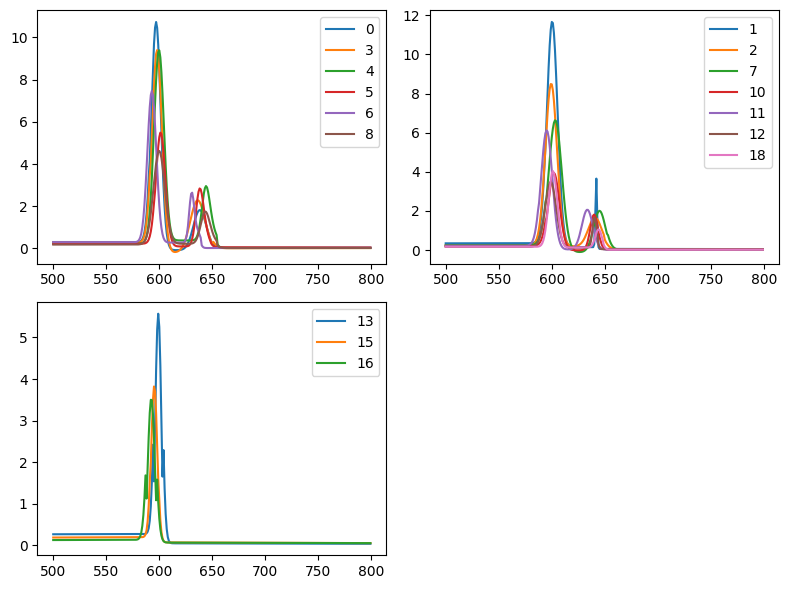

In [81]:
nrows,ncols=2,2
py.figure(figsize=(4*ncols,3*nrows))


x = np.arange(500,800)

#initializes the electron capture peak fitting
conf['xray'] = 'OFF'

for i in range(len(data)):
    if data['CE'][i]==3:
        
        #need to initialize the class to get the correct fit function based on the same recorded initilizing flag in column "CE"
        conf['capture'] = 'three'
        Sn = SnCalibration()
        
        #plot all the fits with the same initilization on the same graph
        ax=py.subplot(nrows,ncols,1)
        
        #need to convert the stored parameter string into the corresponding numerical values and plot Sn.get_fit (the fitting function)
        ax.plot(x,Sn.get_fit(x,*np.float64(data['ecap'][i].replace('[','').replace(']','').split())),label = '%d'%i)
        ax.legend()
        
    if data['CE'][i]==2:
        
        conf['capture'] = 'two'
        Sn = SnCalibration()
        
        ax=py.subplot(nrows,ncols,2)
        
        ax.plot(x,Sn.get_fit(x,*np.float64(data['ecap'][i].replace('[','').replace(']','').split())),label = '%d'%i)
        ax.legend()
        
    if data['CE'][i]==1:
        
        conf['capture'] = 'one'
        Sn = SnCalibration()
        
        ax=py.subplot(nrows,ncols,3)
        ax.plot(x,Sn.get_fit(x,*np.float64(data['ecap'][i].replace('[','').replace(']','').split())),label = '%d'%i)
        
        ax.legend()
        
    if data['CE'][i]==0:
        print('not enough counts for fit: pixel %d'%i)
        conf['capture'] = 'zero'
#         Sn = SnCalibration()
        
#         ax=py.subplot(nrows,ncols,4)
#         ax.plot(x,Sn.get_fit(x,*np.float64(data['ecap'][i].replace('[','').replace(']','').split())),label = '%d'%i)
        
#         ax.legend()

py.tight_layout()

# Look at the fit results for one pixel

In [71]:
#check of index #8 (which corresponds to pixel 101) which has data['CE']==2
conf['capture'] = 'two'
conf['xray'] = 'OFF'
Sn = SnCalibration()

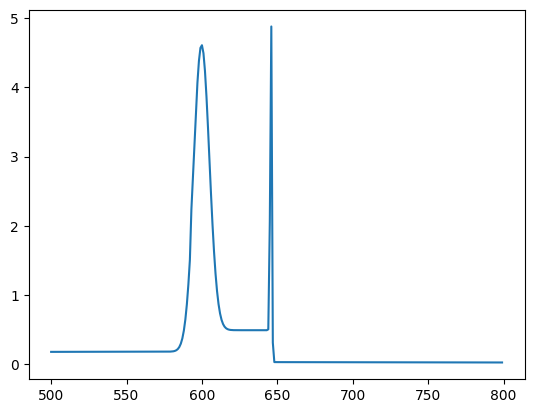

In [72]:
x = np.arange(500,800)

plt.plot(x,Sn.get_fit(x,*np.float64(data['ecap'][8].replace('[','').replace(']','').split())),label = '%d'%i)
plt.show()

In [33]:
#numerical parameters of one electron capture fit
np.float64(data['ecap'][1].replace('[','').replace(']','').split())

array([ 1.15563659e+01,  6.00382409e+02,  7.06942094e+00,  3.52273258e+00,
        6.41930757e+02,  1.08675148e+00,  1.38867598e-01,  1.61401520e-01,
        6.84339285e-05, -4.44610151e-02])

# Fit comparison
- the histogram data is stored in the csv file in the "CE hist" and "Xray hist" columns
- can plot the data and fit result to check the quality
- note: the histogramed data is over the range used for the fit, so the data needs to be shifted to the correct offset based on the fit range (in this case the range was from 300-1400)

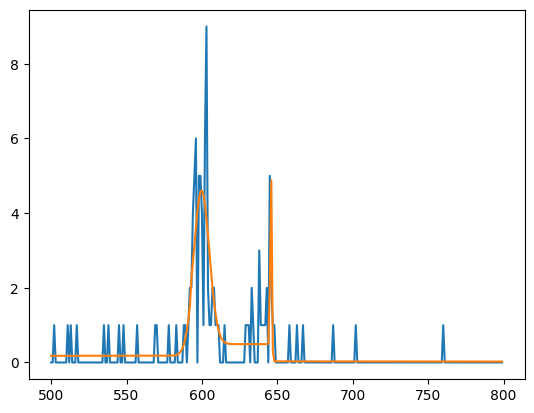

In [73]:
#define the range I want to compare the fit to the data over
x = np.arange(500,800)

#plot the data
#Note: the fit range was from 300-1400, but I want to plot the data from the ADC values of 500-800, which corresponds to the indicies from 200-500 of the stored data
plt.plot(x,np.float64(data['CE hist'][8].replace('[','').replace(']','').split())[200:500])

#plot the fit result
plt.plot(x,Sn.get_fit(x,*np.float64(data['ecap'][8].replace('[','').replace(']','').split())),label = '%d'%i)
plt.show()

# Look at the fit results for the threshold and xray region

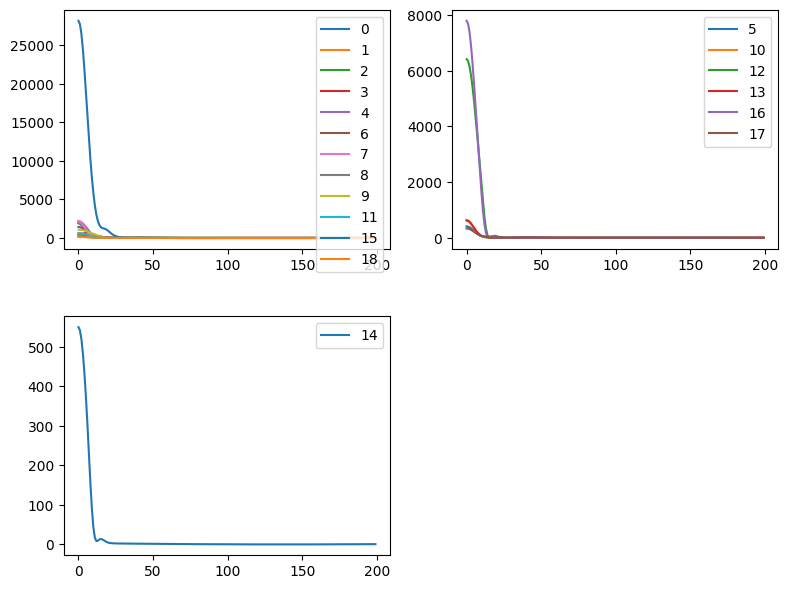

In [15]:
nrows,ncols=2,2
py.figure(figsize=(4*ncols,3*nrows))

x = np.arange(0,200)

#initialize the xray fitting
conf['capture'] = 'OFF'

for i in range(len(data)):
    if data['Xray'][i]==5:
        
        conf['xray'] = 'five'
        Sn = SnCalibration()
        
        ax=py.subplot(nrows,ncols,1)
        
        ax.plot(x,Sn.get_fit(x,*np.float64(data['xray'][i].replace('[','').replace(']','').split())),label = '%d'%i)
        ax.legend()
        
    if data['Xray'][i]==4:
        
        conf['xray'] = 'four'
        Sn = SnCalibration()
        
        ax=py.subplot(nrows,ncols,2)
        
        ax.plot(x,Sn.get_fit(x,*np.float64(data['xray'][i].replace('[','').replace(']','').split())),label = '%d'%i)
        ax.legend()
        
    if data['Xray'][i]==3:
        
        conf['xray'] = 'three'
        Sn = SnCalibration()
        
        ax=py.subplot(nrows,ncols,4)
        
        ax.plot(x,Sn.get_fit(x,*np.float64(data['xray'][i].replace('[','').replace(']','').split())),label = '%d'%i)
        ax.legend()
        
    if data['Xray'][i]==0:
        
        conf['xray'] = 'zero'
        Sn = SnCalibration()
        
        ax=py.subplot(nrows,ncols,3)
        
        ax.plot(x,Sn.get_fit(x,*np.float64(data['xray'][i].replace('[','').replace(']','').split())),label = '%d'%i)
        ax.legend()

py.tight_layout()

# Look at the fit results for one pixel

In [16]:
conf['capture'] = 'OFF'
conf['xray'] = 'five'
Sn = SnCalibration()

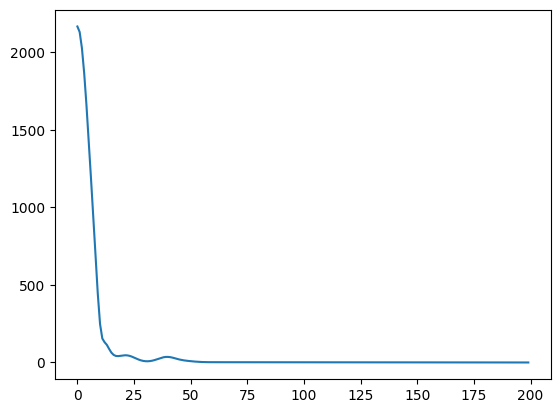

In [17]:
x = np.arange(0,200)

plt.plot(x,Sn.get_fit(x,*np.float64(data['xray'][4].replace('[','').replace(']','').split())),label = '%d'%i)
plt.show()

# Fit comparision

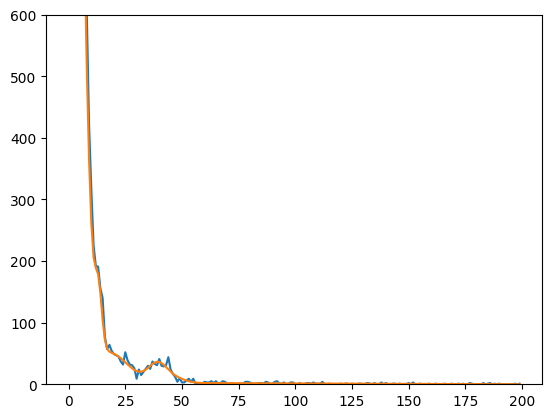

In [20]:
x = np.arange(8,200)
plt.plot(x,np.float64(data['Xray hist'][1].replace('[','').replace(']','').split()))
# plt.hist(np.float64(data['Xray hist'][1].replace('[','').replace(']','').split()),bins = np.arange(0,200))
x = np.arange(0,200)

plt.plot(x,Sn.get_fit(x,*np.float64(data['xray'][1].replace('[','').replace(']','').split())),label = '%d'%i)

plt.ylim(0,600)
plt.show()

# Calibration Model Analysis:
- create new data frames for the fit prameters themselves
- use the centroid locations of the relevant guassians as ADC calibration points
- fit the ADC and eV points to a quadradic and linear calibration model

In [50]:
#set up coumn naming scheme for the fit parameters
names = []
for i in range(10):
    names.append('p%d'%i)
names_xray = []
for i in range(16):
    names_xray.append('p%d'%i)

In [51]:
#create the parameter data frames
df1 = {}
for i in range(len(names)):
    df1[names[i]] = {}
    for j in range(len(data)):
        par_list = np.float64(data['ecap'][j].replace('[','').replace(']','').split()).tolist()
        
        #depending on the fit type used for each pixel, the numer of parameters obtained changes
        #need to add in empty slots for pixels with fewer to be able to construct the dataframe
        if len(par_list) != len(names):
            par_list.extend(['']*(len(names)-len(par_list)))
            
        df1[names[i]][j] = par_list[i]
ecap_data = pd.DataFrame(df1)

df2 = {}
for i in range(len(names_xray)):
    df2[names_xray[i]] = {}
    for j in range(len(data)):
        par_list = np.float64(data['xray'][j].replace('[','').replace(']','').split()).tolist()
        
        if len(par_list) != len(names_xray):
            par_list.extend(['']*(len(names_xray)-len(par_list)))
            
        df2[names_xray[i]][j] = par_list[i]
xray_data = pd.DataFrame(df2)

- Electron capture parameters: (for CE flag 3)
    - p0,p1,p2: 363keV peak amplitude, center, sigma
    - p3,p4,p5: 1st higher lying peak amp, center, sig,
    - p6: gaussian offset
    - p7: background left of peaks
    - p8: background slope
    - p9: background right of peaks
- For other flags, the indicies of the associated parameters with change as things are removed, but they will always be in this order

In [52]:
ecap_data

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9
0,11.821788,594.504866,7.547360,2.777783,636.066865,7.024104,-0.088882,0.414182,-0.000023,0.085729
1,9.225070,600.387573,7.440543,2.484663,646.700989,2.799249,0.21234,0.054042,0.000025,-0.162082
2,10.003866,599.556668,7.197619,2.21306,639.583758,6.867471,0.17942,0.04131,-0.000017,-0.177386
3,10.227949,597.812912,6.128456,2.874536,637.14317,6.446055,-0.035217,0.354017,0.000046,0.0991
4,9.859693,600.452619,7.006678,2.836557,641.482852,4.334855,0.082273,0.302082,-0.000082,-0.13994
5,10.279215,601.421164,3.792291,1.365901,641.541756,8.311252,0.022928,0.276368,0.000007,-0.00453
6,10.469181,592.424267,3.901024,1.238373,630.018811,5.192387,0.388832,-0.094343,0.00008,-0.267316
7,7.439162,604.463108,7.696804,3.241753,643.758083,4.287481,-0.073151,0.338311,-0.000063,0.044501
8,8.158175,600.566513,5.278739,2.811987,639.357505,1.142494,0.270031,-0.034896,-0.000019,-0.264365
9,3.020699,596.707976,7.487347,-0.388015,0.51572,0.000064,0.474054,,,


- Threshold/xray region parameters: (for Xray flag 5)
    - p0,p1,p2: threshold amplitude, center, sigma
    - p3,p4,p5: 1st intermediate gaussian
    - p6,p7,p8: 2nd intermediate gaussian
    - p9,p10,p11: xray double gaussian
    - p12: gaussian offset
    - p13: background constant
    - p14: linear background term
    - p15: quadradic background term
- For other flags, the indicies of the associated parameters with change as things are removed, but they will always be in this order 

In [53]:
xray_data

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15
0,1290.150090,0.0,6.960000,99.522236,13.446773,2.135266,1.235685e+02,-1.015830e+01,4.094206,3.322778e+01,38.627632,5.716543,-6357427.25,6357440.2,-0.198891,0.000736
1,1242.363140,0.0,6.786685,62.224530,13.639845,-1.489419,-1.710929e+02,2.956629e+01,-8.035587,1.523448e+02,28.617015,10.2597,6428973.78,-6428970.75,-0.017151,0.000016
2,195.544073,0.0,8.977431,56.760351,13.778752,2.498383,3.426480e+01,2.148367e+01,5.390104,2.701365e+01,39.843812,6.68986,-6341305.82,6341311.15,-0.061425,0.000195
3,2003.131660,0.0,5.913783,175.529497,12.855061,2.777689,-1.987808e+01,3.175731e+01,-58.002470,3.122001e+01,40.086197,5.352949,6357813.67,-6357774.09,-0.472647,0.00142
4,1673.267110,0.0,6.773921,505.360317,17.890634,-3.208769,-4.671871e+02,1.787918e+01,2.968309,3.090279e+01,39.373737,6.744854,-6373834.33,6373831.96,0.06755,-0.000288
5,665.803361,0.0,5.443936,-3.699249,25.185874,5.254580,2.379859e+01,3.964496e+01,4.312272,-9.512910e+07,95129112.0,-0.170376,0.000623,,,
6,1215.907050,0.0,7.307693,-131.413104,9.462863,2.762387,1.140802e+01,1.985191e+01,3.925024,2.755581e+01,39.349902,5.696849,-6342143.86,6342145.84,-0.01561,0.000041
7,1752.726180,0.0,5.956581,79.394929,13.515964,2.084025,1.449239e+01,1.981852e+01,13.936076,5.008655e+01,40.358744,5.379258,-6361764.91,6361760.74,0.088354,-0.000344
8,307.917672,0.0,14.552324,-47.075091,18.188491,2.790880,9.803609e-02,-2.680396e+02,-200.740307,2.665864e+01,38.536559,-7.079743,-110106434.0,110106437.0,-0.026167,0.000067
9,217.184151,0.0,3.018701,123.728601,13.086435,3.328995,-6.642692e-01,2.765415e+01,0.168144,1.840621e+01,39.902054,5.531101,-6459604.71,6459615.3,-0.140952,0.000474


In [54]:
#define the calibration models
def calibration_quad(x,a,b,c):
    return a*x**2 + b*x + c

def calibration_lin(x,a,b):
    return a*x + b

In [55]:
#obtain the relevant centroids and sigmas for the ADC points
calibration_data = []
sig_data = []

for i in range(len(data)):
    points = []
    sig = []
    if data['CE'][i]==3 or data['CE'][i]==2:
        points.append(ecap_data['p1'][i])
        points.append(ecap_data['p4'][i])
        
        sig.append(ecap_data['p2'][i])
        sig.append(ecap_data['p5'][i])
        
    if data['CE'][i]==1:
        points.append(ecap_data['p1'][i])
        sig.append(ecap_data['p2'][i])
        
    if data['Xray'][i]==5:
        points.append(xray_data['p10'][i])
        sig.append(xray_data['p11'][i])
        
    if data['Xray'][i]==4:
        points.append(xray_data['p7'][i])
        sig.append(xray_data['p8'][i])
    
    calibration_data.append(points)
    sig_data.append(sig)

In [56]:
#ADC points
calibration_data

[[np.float64(594.504866), 636.066865, 38.6276316],
 [np.float64(600.387573), 646.700989, 28.617015],
 [np.float64(599.556668), 639.583758, 39.8438125],
 [np.float64(597.812912), 637.14317, 40.0861975],
 [np.float64(600.452619), 641.482852, 39.373737],
 [np.float64(601.421164), 641.541756, np.float64(39.644959)],
 [np.float64(592.424267), 630.018811, 39.3499024],
 [np.float64(604.463108), 643.758083, 40.3587443],
 [np.float64(600.566513), 639.357505, 38.5365588],
 [np.float64(596.707976), 39.9020541],
 [np.float64(600.982246), 642.64045, np.float64(40.2684272)],
 [np.float64(595.060212), 629.121731, 39.7051121],
 [np.float64(599.699345), 639.965575, np.float64(40.0160708)],
 [np.float64(597.533032), 638.904901, np.float64(39.0638985)],
 [],
 [np.float64(595.574168), 634.507191, np.float64(39.1852919)],
 [np.float64(594.133136), np.float64(39.2549507)],
 [np.float64(597.864245), np.float64(41.5468158)],
 [np.float64(601.924279), 640.419112, 40.0110337]]

In [57]:
#sort the points in order
ADC_data = [np.sort(calibration_data[i]) for i in range(len(calibration_data))]
ADC_data

[array([ 38.6276316, 594.504866 , 636.066865 ]),
 array([ 28.617015, 600.387573, 646.700989]),
 array([ 39.8438125, 599.556668 , 639.583758 ]),
 array([ 40.0861975, 597.812912 , 637.14317  ]),
 array([ 39.373737, 600.452619, 641.482852]),
 array([ 39.644959, 601.421164, 641.541756]),
 array([ 39.3499024, 592.424267 , 630.018811 ]),
 array([ 40.3587443, 604.463108 , 643.758083 ]),
 array([ 38.5365588, 600.566513 , 639.357505 ]),
 array([ 39.9020541, 596.707976 ]),
 array([ 40.2684272, 600.982246 , 642.64045  ]),
 array([ 39.7051121, 595.060212 , 629.121731 ]),
 array([ 40.0160708, 599.699345 , 639.965575 ]),
 array([ 39.0638985, 597.533032 , 638.904901 ]),
 array([], dtype=float64),
 array([ 39.1852919, 595.574168 , 634.507191 ]),
 array([ 39.2549507, 594.133136 ]),
 array([ 41.5468158, 597.864245 ]),
 array([ 40.0110337, 601.924279 , 640.419112 ])]

In [58]:
eV_points = [22.59,363.758,387.461]

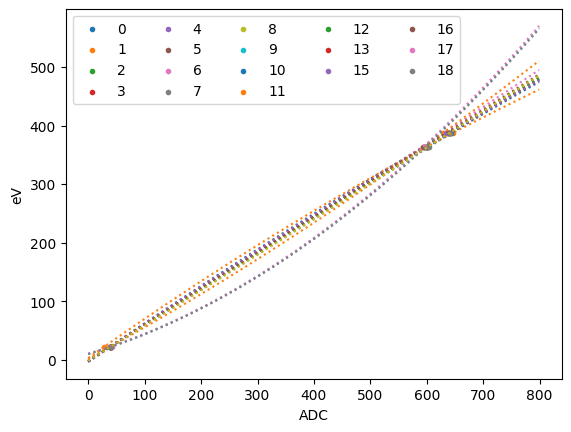

In [59]:
#do a quadradic fit to the ADC and eV data

fit_pars_quad = []
x = np.arange(0,800)
for i in range(len(ADC_data)):
    
    #if there are no points, skip the pixel
    if len(ADC_data[i])==0:
        pass
    
    #only include the eV points associated with the corresponding ADC value
    elif len(ADC_data[i])<3:
        a, b,c = np.polyfit(ADC_data[i],eV_points[:2], deg=2)
        plt.scatter(ADC_data[i],eV_points[:2],marker = '.',label = '%d'%i)
    else:
        a, b,c = np.polyfit(ADC_data[i], eV_points, deg=2)
        plt.scatter(ADC_data[i],eV_points,marker = '.',label = '%d'%i)
    
    #plot all the calibration fits on the same graph
    fit_pars_quad.append([a,b,c])
    plt.plot(x,calibration_quad(x,fit_pars_quad[i][0],fit_pars_quad[i][1],fit_pars_quad[i][2]),linestyle = ':')
    
plt.legend(loc="upper left", ncol=5)
plt.xlabel('ADC')
plt.ylabel('eV')
plt.show()

In [60]:
#store the quadradic fit parameters
quad = np.array(fit_pars_quad)[:,0]
lin = np.array(fit_pars_quad)[:,1]
intercept_quad = np.array(fit_pars_quad)[:,2]

In [61]:
quad

array([-7.27143544e-05, -1.37345984e-04, -2.89578316e-05, -1.51510053e-05,
       -5.04246476e-05, -2.74273905e-05,  2.30806980e-05, -2.63339727e-06,
        6.68382288e-06,  5.11601262e-04, -6.55167000e-05,  1.38380677e-04,
       -3.48634160e-05, -6.33051894e-05, -6.33051894e-05, -7.33696486e-06,
        5.15595253e-04,  5.11091682e-04,  1.43081888e-05])

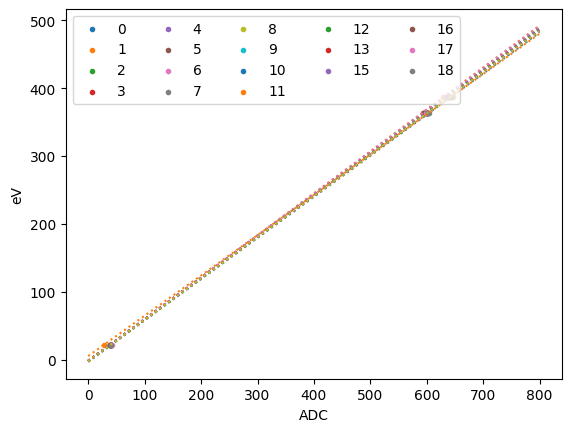

In [62]:
#do a linear fit to the calibration points

fit_pars = []
x = np.arange(0,800)
for i in range(len(ADC_data)):
    
    if len(ADC_data[i])==0:
        pass
    
    elif len(ADC_data[i])<3:
        a, b = np.polyfit(ADC_data[i],eV_points[:2], deg=1)
        plt.scatter(ADC_data[i],eV_points[:2],marker = '.',label = '%d'%i)
    else:
        a, b = np.polyfit(ADC_data[i],eV_points, deg=1)
        plt.scatter(ADC_data[i],eV_points,marker = '.',label = '%d'%i)
        
    fit_pars.append([a,b])
    plt.plot(x,calibration_lin(x,fit_pars[i][0],fit_pars[i][1]),linestyle = ':')
    
plt.legend(loc="upper left", ncol=5)
plt.xlabel('ADC')
plt.ylabel('eV')
plt.show()

In [63]:
#store the linear fit parameters
slope = np.array(fit_pars)[:,0]
intercept = np.array(fit_pars)[:,1]

In [64]:
slope

array([0.61201898, 0.59301347, 0.60888183, 0.61137338, 0.60687722,
       0.60667652, 0.61734809, 0.60473721, 0.60717502, 0.61272337,
       0.60689358, 0.61696053, 0.60877429, 0.60940267, 0.60940267,
       0.61302057, 0.61485207, 0.61326139, 0.60746598])

# Resolution Analysis
- use the obtained sigma values from the fits for the relevant gaussians used in the calibration
- calculate the total resolution by: 
  $\sigma_{TOT}=\sqrt(\sum\sigma_{i}^2)$
- this can be extended similar to the calibration model analysis to include a resultion model

In [65]:
#the obtained sigma from the fit for the relevant ADC points used in the calibration
sig_data

[[np.float64(7.54735991), 7.02410408, 5.71654262],
 [np.float64(7.44054279), 2.79924942, 10.2596998],
 [np.float64(7.19761888), 6.86747079, 6.6898597],
 [np.float64(6.12845614), 6.44605519, 5.35294862],
 [np.float64(7.0066777), 4.33485549, 6.74485385],
 [np.float64(3.79229134), 8.31125186, np.float64(4.31227207)],
 [np.float64(3.90102407), 5.19238711, 5.69684881],
 [np.float64(7.69680405), 4.28748132, 5.37925793],
 [np.float64(5.27873899), 1.14249356, -7.07974307],
 [np.float64(7.487347), 5.53110139],
 [np.float64(7.25450023), -2.14046738, np.float64(4.39425604)],
 [np.float64(7.18920237), 13.5683358, 4.94585205],
 [np.float64(6.68384021), 7.53452122, np.float64(6.37070154)],
 [np.float64(7.72201611), 8.22452303, np.float64(4.92435403)],
 [],
 [np.float64(6.97089886), 7.88979283, np.float64(4.72155415)],
 [np.float64(7.11134573), np.float64(5.49416924)],
 [np.float64(4.36421859), np.float64(5.33877138)],
 [np.float64(8.42425442), 11.0485068, 5.50398696]]

In [66]:
#calculate the total resolution and convert it to eV using the quadradic calibration model fit parameters
for i in range(len(sig_data)):
    if sig_data[i]==[]:
        pass
    else:
        print(np.sqrt(np.sum(np.array(sig_data[i])**2))*quad[i] + np.sqrt(np.sum(np.array(sig_data[i])**2))*lin[i] +  intercept_quad[i])

4.9898894821627655
12.018825939543115
5.140853301313233
4.156029685685405
4.2738979988940375
4.1719895990562055
4.058056435643977
4.377628790418989
4.719319937722837
12.998929791177206
2.192389706561538
9.963262201419267
4.890645003342782
5.263341792679443
5.519847361536528
13.074331163659156
11.784984884905748
7.578157794114115


In [67]:
#calculate the total resolution and convert it to eV using the linear calibration model fit parameters
for i in range(len(sig_data)):
    if sig_data[i]==[]:
        pass
    else:
        print(np.sqrt(np.sum(np.array(sig_data[i])**2))*slope[i]+intercept[i])

6.226701064759498
13.462958910289142
5.6524422219279575
4.440652917120631
5.199171711650727
4.689060311953277
3.6144656865485825
4.428156350912022
4.593250603023851
3.8447881038177187
3.5167138462984884
7.966414005104354
5.512485015813716
6.339645349943159
5.6474394481088925
3.9793788167835134
1.3397287465971988
7.352243518596759
